# Ocular Diseases Classification using Deep Learning Techniques
## Project Overview
This project aims to develop a deep learning model for the classification of retinal images to identify various eye diseases. The focus is on four specific conditions: **Normal, Diabetic Retinopathy, Cataract, and Glaucoma**. 

By analyzing these images, we can assist in early diagnosis and treatment, ultimately improving patient outcomes.

## Dataset Description
The dataset used for this project comprises retinal images categorized into four classes:
* Normal: Healthy retinal images with no abnormalities
* Diabetic Retinopathy: Images showing signs of diabetic eye disease.
* Cataract: Images indicating the presence of cataracts in the lens of the eye.
* Glaucoma: Images that reveal signs of glaucoma, which affects the optic nerve.

Each class contains approximately 1,000 images, providing a balanced dataset for training and evaluation. The images have been sourced from various reputable databases, including:

* IDRiD: Indian Diabetic Retinopathy Image Dataset
* Ocular Recognition: A database focused on ocular disease recognition
* HRF: High-Resolution Fundus dataset

Source of Dataset:
*https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification/data*

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras_tqdm import TQDMNotebookCallback
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from powermanagement import long_running 

%autosave 30

Autosaving every 30 seconds


In [2]:
telltimefnx = lambda :print(f"Time Now: {pd.Timestamp.now().strftime('%Y.%m.%d %I:%M %p')}")
telltimefnx()

Time Now: 2024.09.30 09:34 PM


## Dataset Exploration
* Identification of number of samples for each category
* Creation of a unified dataframe, containing paths and respective category

In [3]:
dataPath = r"C:\Users\asuto\Desktop\Work\Eye Diseases\dataset"
os.listdir(dataPath)

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [4]:
%%time
total = 0
for disease in os.listdir(dataPath):
    diseasePath = os.path.join(dataPath,disease)
    print(f"Number of samples for {disease} case: {len(os.listdir(diseasePath))}")
    total += len(os.listdir(diseasePath))
print(f"Total samples: {total}")

Number of samples for cataract case: 1038
Number of samples for diabetic_retinopathy case: 1098
Number of samples for glaucoma case: 1007
Number of samples for normal case: 1074
Total samples: 4217
CPU times: total: 31.2 ms
Wall time: 138 ms


In [5]:
%%time
diseaseMap = {"filepath":[],"label":[]}

for disease in tqdm(os.listdir(dataPath)):
    diseasePath = os.path.join(dataPath,disease)

    for path in os.listdir(diseasePath):
        diseaseMap['filepath'].append(os.path.join(dataPath,disease,path))
        diseaseMap['label'].append(disease)

opticDf = pd.DataFrame(diseaseMap).sample(frac=1)
opticDf.head()

100%|██████████| 4/4 [00:00<00:00, 173.35it/s]

CPU times: total: 78.1 ms
Wall time: 38.6 ms


,filepath,label
356,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
4045,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
1156,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
3776,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
2963,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma


In [6]:
opticDf.to_csv(r"C:\Users\asuto\Desktop\Work\Eye Diseases\opticDiseasesDataframe.csv",index=False)

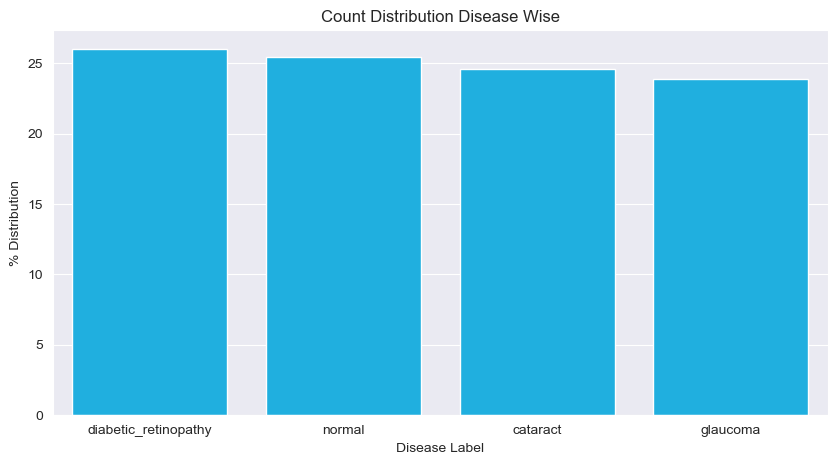

In [7]:
plt.figure(figsize=(10,5),dpi=100)
sns.barplot(opticDf.label.value_counts(normalize=True)*100,color='deepskyblue')
plt.xlabel("Disease Label")
plt.ylabel("% Distribution")
plt.title('Count Distribution Disease Wise')
plt.show()

## Image Exploration & Brief on Ocular Diseases
### Brief on Ocular Diseases
* **Normal:** Normal retinal images show a healthy eye without any issues. This is the baseline for comparison when looking for signs of disease.
* **Diabetic Retinopathy:** Diabetic Retinopathy is a condition that can happen in people with diabetes. It affects the blood vessels in the retina and can lead to vision problems. Early signs include tiny bulges and spots on the retina. If not caught early, it can worsen and cause serious vision loss.
* **Cataract:** Cataracts make the lens of the eye cloudy, which can blur vision. They are often related to aging but can also be caused by other factors like diabetes or eye injuries. People with cataracts may notice difficulty seeing at night or glare from bright lights. Surgery can help restore clear vision.

* **Glaucoma:** Glaucoma involves damage to the optic nerve, often due to high pressure in the eye. It can lead to vision loss if not treated. Many people don’t notice symptoms in the early stages, so regular eye check-ups are important for detection. There are different types, with open-angle glaucoma being the most common.

**Importance of Early Detection:**

Identification these diseases early is crucial to prevent vision loss. Regular eye exams can help identify problems before they become serious, making it important to analyze eye images for signs of these conditions.



In [8]:
def displayImg(sample,scaleImage = True):
    imgName,label = sample['filepath'].item().split('\\')[-1],sample['label'].item()
    path = sample['filepath'].item()
    img = mpimg.imread(path)

    if scaleImage:
        img = img / 255
        
    plt.figure(figsize= (6,6),dpi=80)
    imgplot = plt.imshow(img)
    plt.title(f"{imgName}:{label}",color= 'blue', fontsize= 12)
    plt.show()
    return img

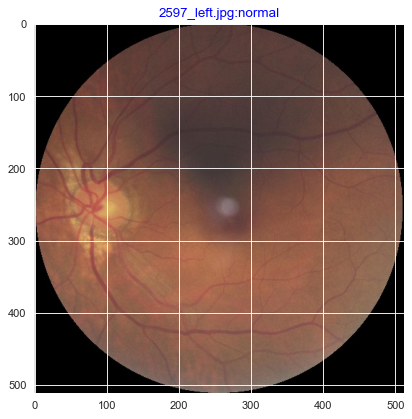

In [9]:
sample = opticDf.sample(1)
img = displayImg(sample)

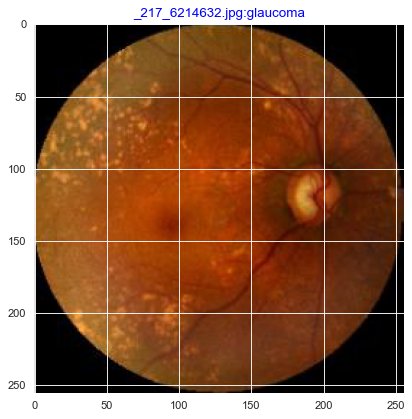

In [10]:
sample = opticDf.sample(1)
img = displayImg(sample)

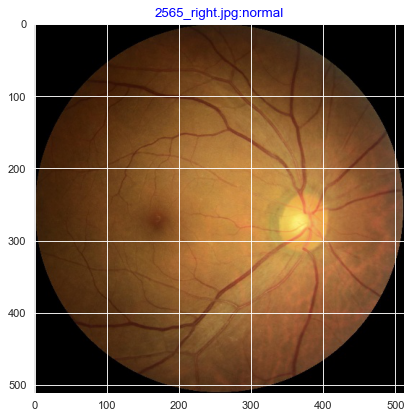

In [23]:
sample = opticDf.sample(1)
img = displayImg(sample)

In [12]:
print(img.shape)

(1632, 2464, 3)


---
## Data Splitting, Image Preprocessing and Generator

### Train Test Split
* Creation of Training, Validation and Testing Samples
* Splitting the dataframe into 70% Training, 15% Validation and 15% Testing datapoints.

In [13]:
opticDf.head()

,filepath,label
356,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,cataract
4045,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
1156,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,diabetic_retinopathy
3776,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,normal
2963,C:\Users\asuto\Desktop\Work\Eye Diseases\datas...,glaucoma


In [14]:
#Creating Training Samples and a Dummy DF
trainSamples,dumSamples = train_test_split(opticDf,test_size=0.3,stratify=opticDf['label'])
#Creating Testing and Validation Samples from the Dummy DF
testSamples,validSamples = train_test_split(dumSamples,test_size=0.5,stratify=dumSamples['label'])

In [15]:
print("Training Data Size:", trainSamples.shape[0])
print("Validation Data Size:", validSamples.shape[0])
print("Testing Data Size:", testSamples.shape[0])

Training Data Size: 2951
Validation Data Size: 633
Testing Data Size: 633


### Image Generator
Preprocessing Steps:
* Image Resizing: Original (512,512) --> Standard (256,256)
* Image Standardization: IMG x (1/255)

**Image Resizing:**
Image resizing ensures all images have the same dimensions, which is essential for model compatibility and processing.

**Image Standardization:**
Image standardization ensures consistent pixel value distributions across all images, making it easier for the model to learn and perform well. By reducing the impact of lighting and contrast differences, it allows the model to focus on the actual patterns in the data.

In [16]:
img.shape

(1632, 2464, 3)

In [17]:
#Target Image Size. Original Image Size is (512,512)
imageSize = (256, 256)
color = 'rgb'
colorChannel = 3
imageShape = (imageSize[0],imageSize[1],colorChannel)
batch_size = 6

imgGen = ImageDataGenerator(rescale = 1/255)

In [18]:
trainGen = imgGen.flow_from_dataframe(trainSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
valGen = imgGen.flow_from_dataframe(validSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)
testGen = imgGen.flow_from_dataframe(testSamples,x_col='filepath',y_col='label',class_mode='categorical',color_mode=color,target_size=imageSize,batch_size=batch_size)

Found 2951 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.


Image Shape after shape preprocessing: (256, 256, 3)



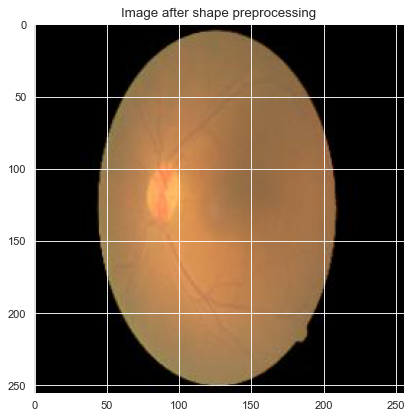

In [19]:
sampleImg = next(iter(trainGen))[0][0]
print(f"Image Shape after shape preprocessing: {sampleImg.shape}\n")

plt.figure(figsize= (6,6),dpi=80)
imgplot = plt.imshow(sampleImg)
plt.title("Image after shape preprocessing")
plt.show()

In [20]:
np.max(sampleImg),np.min(sampleImg)

(1.0, 0.0)

---
## Model Development
Using the power of Convolution and Convolutional Neural Networks

**Convolutional Neural Networks:**

Convolutional Neural Networks (CNNs) are a type of deep learning architecture designed for processing grid-like data, such as images. They utilize convolutional layers to automatically detect features like edges and textures by applying filters to the input. Pooling layers reduce the spatial dimensions, helping to maintain important information while lowering computational costs. CNNs typically include fully connected layers at the end for classification tasks. They are highly effective in tasks such as image recognition and object detection due to their ability to learn hierarchical features.

**Sample CNN Architecture**

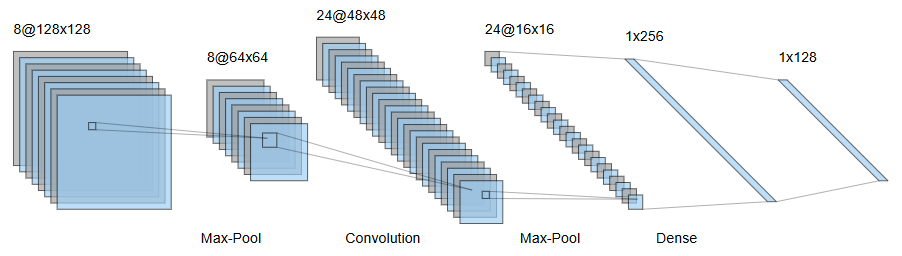

In [21]:
@long_running
def modelTrainingFnx(model,epochs):
    tf.keras.backend.clear_session()
    # history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs,verbose=0, callbacks=[TQDMNotebookCallback()])
    history = model.fit(x=trainGen,validation_data=valGen,epochs=epochs)
    return model,history 

---
### Custom Model 1

In [41]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,strides=(1,1),activation='relu',padding='same',input_shape=imageShape),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=128,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

#### Model Training

In [43]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=10)
telltimefnx()

Time Now: 2024.09.30 10:13 AM
Epoch 1/10
492/492 [==============================] - 46s 71ms/step - loss: 0.9511 - accuracy: 0.5639 - val_loss: 0.7633 - val_accuracy: 0.6035
Epoch 2/10
492/492 [==============================] - 32s 66ms/step - loss: 0.6562 - accuracy: 0.7130 - val_loss: 0.6215 - val_accuracy: 0.7235
Epoch 3/10
492/492 [==============================] - 34s 69ms/step - loss: 0.5265 - accuracy: 0.7757 - val_loss: 0.4978 - val_accuracy: 0.7867
Epoch 4/10
492/492 [==============================] - 36s 72ms/step - loss: 0.5084 - accuracy: 0.7906 - val_loss: 0.5276 - val_accuracy: 0.7678
Epoch 5/10
492/492 [==============================] - 37s 74ms/step - loss: 0.4378 - accuracy: 0.8211 - val_loss: 0.4547 - val_accuracy: 0.8041
Epoch 6/10
492/492 [==============================] - 36s 74ms/step - loss: 0.4099 - accuracy: 0.8360 - val_loss: 0.4693 - val_accuracy: 0.8025
Epoch 7/10
492/492 [==============================] - 36s 74ms/step - loss: 0.3525 - accuracy: 0.8584 - va

#### Loss Progression

In [44]:
historyDf = pd.DataFrame(history.history).reset_index()
historyDf['index'] += 1
historyDf.head()

,index,loss,accuracy,val_loss,val_accuracy
0,1,0.951099,0.563877,0.763296,0.603476
1,2,0.656235,0.712979,0.621548,0.723539
2,3,0.526516,0.775669,0.497814,0.786730
3,4,0.508363,0.790579,0.527649,0.767772
4,5,0.437792,0.821078,0.454690,0.804107


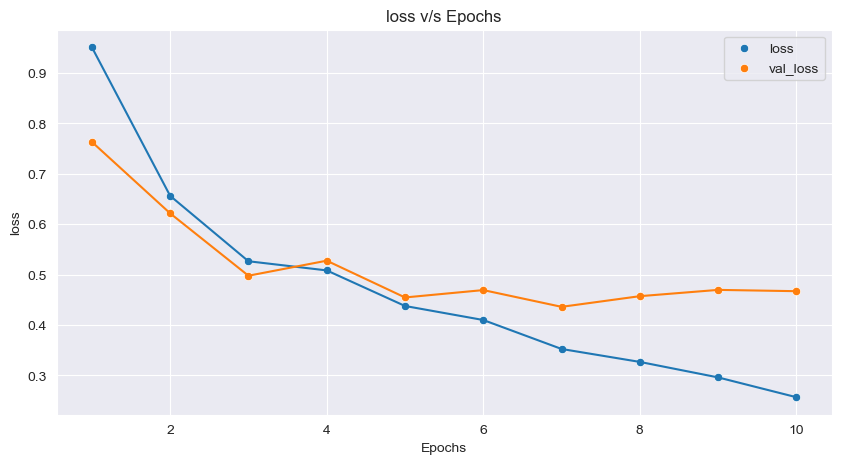

In [45]:
metric = 'loss'

plt.figure(figsize=(10,5),dpi=100)
sns.lineplot(data=historyDf,x='index',y=metric)
sns.scatterplot(data=historyDf,x='index',y=metric,label=metric)

sns.lineplot(data=historyDf,x='index',y='val_loss')
sns.scatterplot(data=historyDf,x='index',y='val_loss',label='val_loss')

plt.title(f'{metric} v/s Epochs')
plt.xlabel('Epochs')
plt.show()

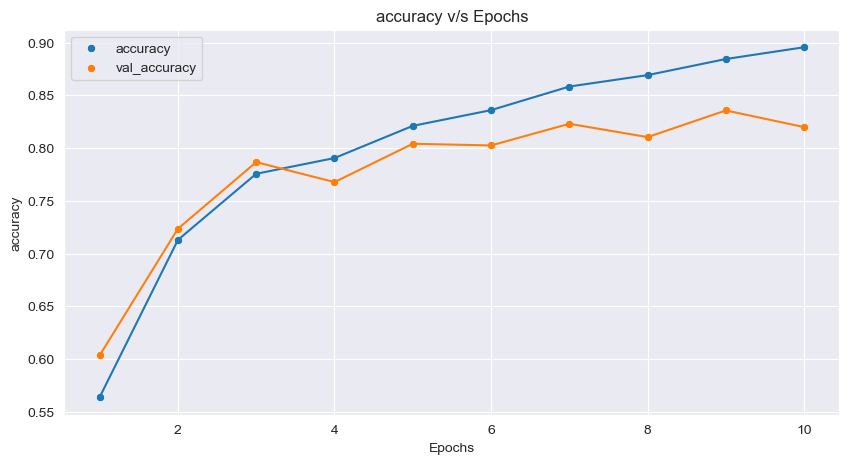

In [46]:
metric = 'accuracy'

plt.figure(figsize=(10,5),dpi=100)
sns.lineplot(data=historyDf,x='index',y=metric)
sns.scatterplot(data=historyDf,x='index',y=metric,label=metric)

sns.lineplot(data=historyDf,x='index',y='val_accuracy')
sns.scatterplot(data=historyDf,x='index',y='val_accuracy',label='val_accuracy')

plt.title(f'{metric} v/s Epochs')
plt.xlabel('Epochs')
plt.show()

#### Model Evaluation

In [47]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)

106/106 [==============================] - 5s 45ms/step - loss: 0.5002 - accuracy: 0.8041


In [51]:
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )

Test Loss:  0.5001512169837952
Test Accuracy: 80.41074275970459 %


In [74]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

106/106 [==============================] - 5s 45ms/step
CPU times: total: 12.8 s
Wall time: 12.1 s


In [70]:
print(classification_report(testGen.classes, yPred, target_names= classes))

                      precision    recall  f1-score   support

            cataract       0.28      0.24      0.26       156
diabetic_retinopathy       0.29      0.27      0.28       165
            glaucoma       0.22      0.19      0.20       151
              normal       0.28      0.36      0.32       161

            accuracy                           0.27       633
           macro avg       0.27      0.27      0.26       633
        weighted avg       0.27      0.27      0.27       633



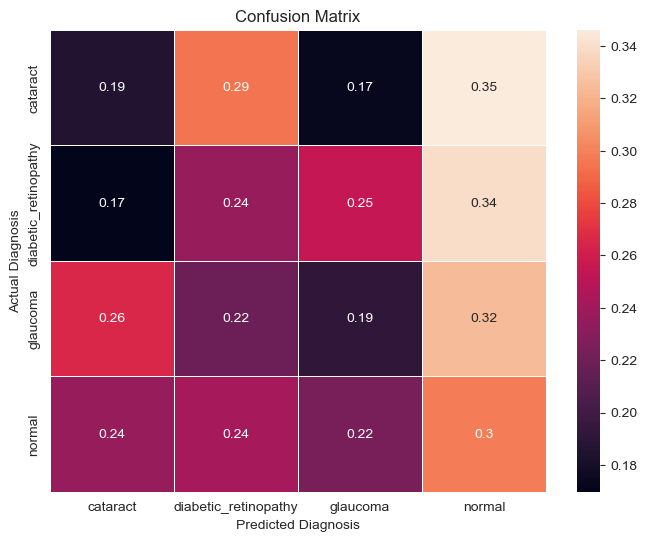

In [92]:
conf_matrix = confusion_matrix(testGen.classes, yPred,normalize='true')

plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=classes,yticklabels=classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()

### Custom Model 2

In [41]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16,kernel_size=4,strides=(1,1),activation='relu',padding='same',input_shape=imageShape),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=32,kernel_size=5,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=64,kernel_size=5,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(4),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,strides=(1,1),activation='relu',padding='same'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      784       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

#### Model Training

In [44]:
%%time
telltimefnx()
model,history = modelTrainingFnx(model,epochs=20)
telltimefnx()

Time Now: 2024.09.30 09:44 PM
Epoch 1/20
492/492 [==============================] - 35s 57ms/step - loss: 1.2575 - accuracy: 0.3843 - val_loss: 0.9033 - val_accuracy: 0.5893
Epoch 2/20
492/492 [==============================] - 26s 53ms/step - loss: 0.8651 - accuracy: 0.5890 - val_loss: 0.7737 - val_accuracy: 0.7109
Epoch 3/20
492/492 [==============================] - 29s 58ms/step - loss: 0.7420 - accuracy: 0.6476 - val_loss: 0.6534 - val_accuracy: 0.7014
Epoch 4/20
492/492 [==============================] - 27s 54ms/step - loss: 0.6672 - accuracy: 0.6832 - val_loss: 0.6737 - val_accuracy: 0.6667
Epoch 5/20
492/492 [==============================] - 32s 66ms/step - loss: 0.6455 - accuracy: 0.6957 - val_loss: 0.6051 - val_accuracy: 0.7125
Epoch 6/20
492/492 [==============================] - 30s 61ms/step - loss: 0.6261 - accuracy: 0.7015 - val_loss: 0.5970 - val_accuracy: 0.7172
Epoch 7/20
492/492 [==============================] - 30s 60ms/step - loss: 0.6119 - accuracy: 0.7140 - va

#### Loss Progression

In [45]:
historyDf = pd.DataFrame(history.history).reset_index()
historyDf['index'] += 1
historyDf.head()

,index,loss,accuracy,val_loss,val_accuracy
0,1,1.257512,0.384277,0.903326,0.589257
1,2,0.865078,0.588953,0.773721,0.710900
2,3,0.742046,0.647577,0.653377,0.701422
3,4,0.667151,0.683158,0.673699,0.666667
4,5,0.645458,0.695696,0.605129,0.712480


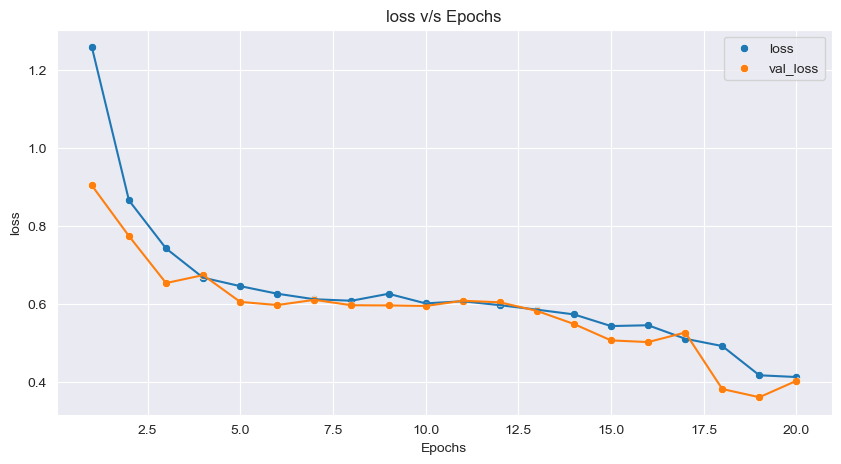

In [46]:
metric = 'loss'

plt.figure(figsize=(10,5),dpi=100)
sns.lineplot(data=historyDf,x='index',y=metric)
sns.scatterplot(data=historyDf,x='index',y=metric,label=metric)

sns.lineplot(data=historyDf,x='index',y='val_loss')
sns.scatterplot(data=historyDf,x='index',y='val_loss',label='val_loss')

plt.title(f'{metric} v/s Epochs')
plt.xlabel('Epochs')
plt.show()

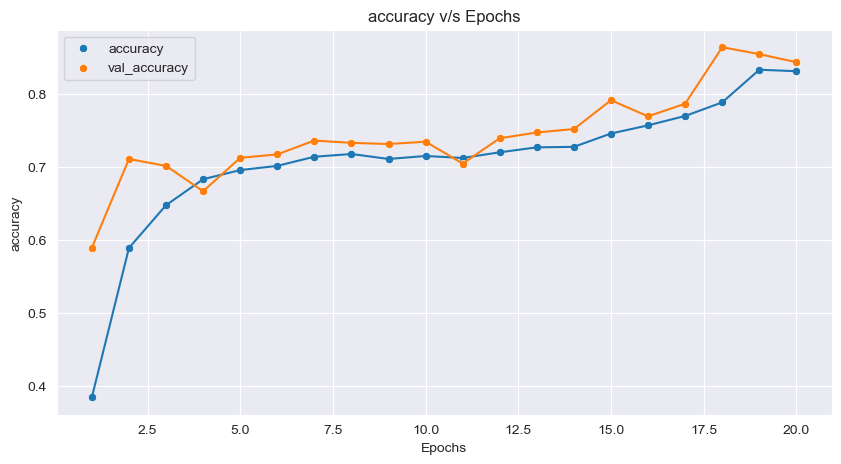

In [47]:
metric = 'accuracy'

plt.figure(figsize=(10,5),dpi=100)
sns.lineplot(data=historyDf,x='index',y=metric)
sns.scatterplot(data=historyDf,x='index',y=metric,label=metric)

sns.lineplot(data=historyDf,x='index',y='val_accuracy')
sns.scatterplot(data=historyDf,x='index',y='val_accuracy',label='val_accuracy')

plt.title(f'{metric} v/s Epochs')
plt.xlabel('Epochs')
plt.show()

#### Model Evaluation

In [48]:
test_score = model.evaluate(testGen, steps= None, verbose= 1)
print("Test Loss: ", test_score[0])
print(f"Test Accuracy: {(test_score[1])*100} %", )

106/106 [==============================] - 9s 82ms/step - loss: 0.4022 - accuracy: 0.8436
Test Loss:  0.40224993228912354
Test Accuracy: 84.36018824577332 %


In [49]:
%%time
classes = list(testGen.class_indices.keys())
preds = model.predict(testGen)
yPred = np.argmax(preds, axis=1)

print(classification_report(testGen.classes, yPred, target_names= classes))

106/106 [==============================] - 8s 67ms/step
                      precision    recall  f1-score   support

            cataract       0.24      0.22      0.23       156
diabetic_retinopathy       0.28      0.28      0.28       165
            glaucoma       0.21      0.18      0.19       151
              normal       0.26      0.32      0.28       161

            accuracy                           0.25       633
           macro avg       0.25      0.25      0.25       633
        weighted avg       0.25      0.25      0.25       633

CPU times: total: 10.2 s
Wall time: 8.18 s


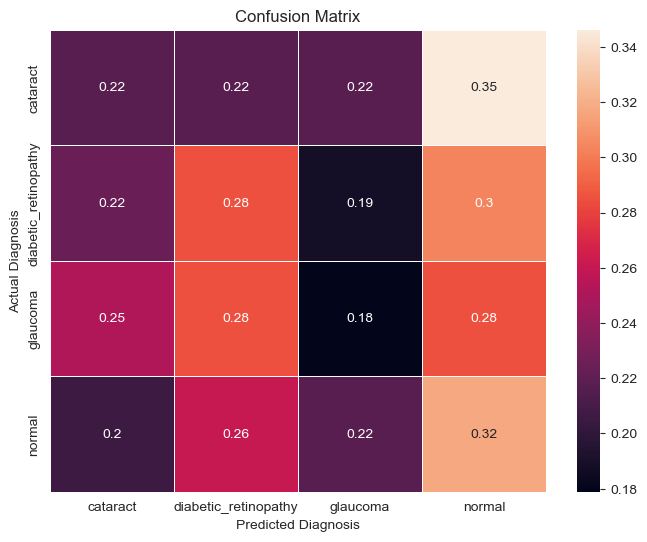

CPU times: total: 359 ms
Wall time: 407 ms


In [50]:
%%time
conf_matrix = confusion_matrix(testGen.classes, yPred,normalize='true')

plt.figure(figsize=(8,6),dpi=100)
ax = sns.heatmap(conf_matrix, annot=True,xticklabels=classes,yticklabels=classes,linewidths=0.5)
plt.xlabel("Predicted Diagnosis")
plt.ylabel("Actual Diagnosis")
plt.title("Confusion Matrix")
plt.show()